In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

zip_filename = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("extracted_data")

os.listdir("extracted_data")


Saving archive(1).zip to archive(1).zip


['zero-indexed-files.txt',
 'one-indexed-files-notrash_val.txt',
 'one-indexed-files-notrash_train.txt',
 'Garbage classification',
 'garbage classification',
 'one-indexed-files-notrash_test.txt',
 'one-indexed-files.txt']

In [ ]:
# Install Ultralytics YOLO (latest version - typically includes YOLOv8 and newer)
!pip install ultralytics --upgrade



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
# Define the content of the YAML file
yaml_content = """
train: /content/extracted_data/train/images
val: /content/extracted_data/val/images

nc: 6

names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
"""

# Write the content to data.yaml
with open("/content/data.yaml", "w") as f:
    f.write(yaml_content)

# Confirm it was created
print("data.yaml created at /content/data.yaml")


data.yaml created at /content/data.yaml


In [ ]:
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model (you can use yolov8n, yolov8s, yolov8m, or yolov8x)
model = YOLO('yolov8n.pt')


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim



In [ ]:
data_dir = '/content/extracted_data'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
print("Classes:", class_names)


Classes: ['Garbage classification', 'garbage classification']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Adjust final layer
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/len(train_dataset):.2f}%")


Epoch 1, Loss: 0.7569717520803917, Accuracy: 50.01%
Epoch 2, Loss: 0.7135081103467565, Accuracy: 49.22%
Epoch 3, Loss: 0.7042712954085643, Accuracy: 48.80%
Epoch 4, Loss: 0.7035182287373881, Accuracy: 50.19%
Epoch 5, Loss: 0.6999486910076592, Accuracy: 50.41%


In [ ]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

print(f"Validation Accuracy: {100*correct/len(val_dataset):.2f}%")


Validation Accuracy: 51.53%


In [ ]:
torch.save(model.state_dict(), "garbage_classifier.pth")


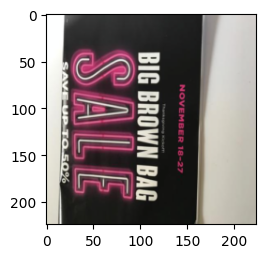

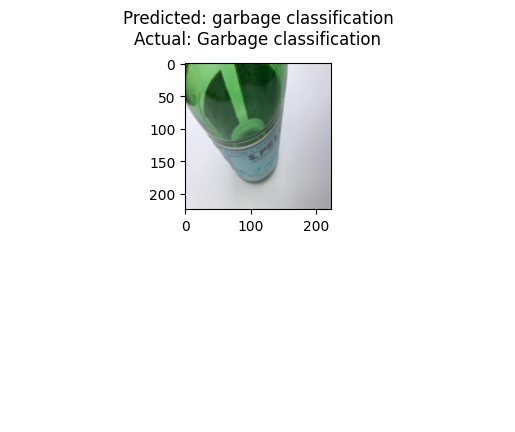

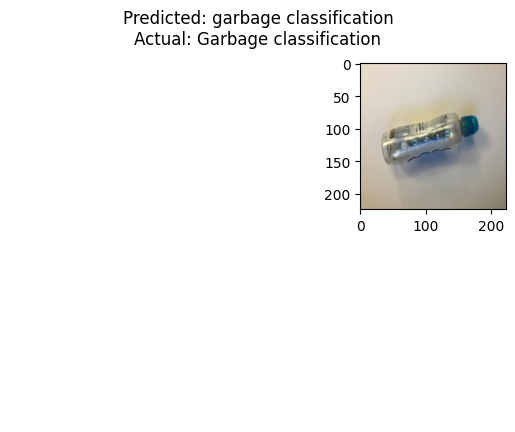

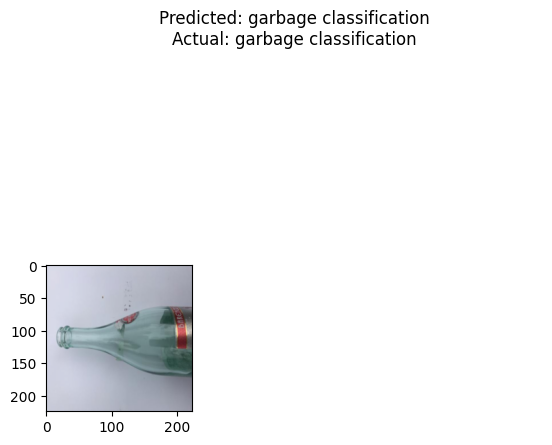

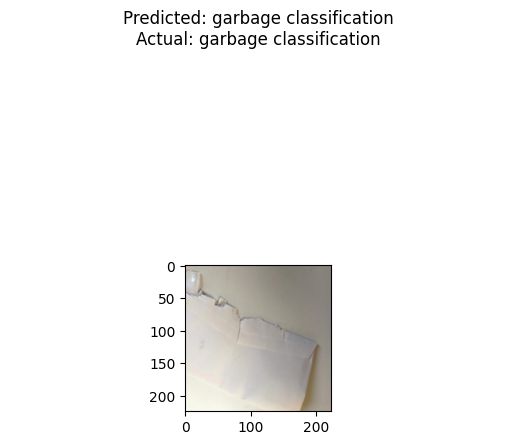

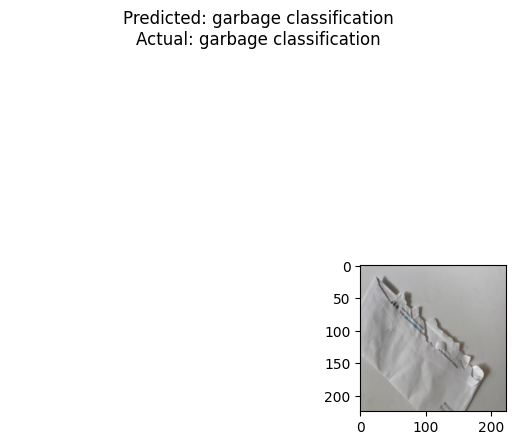

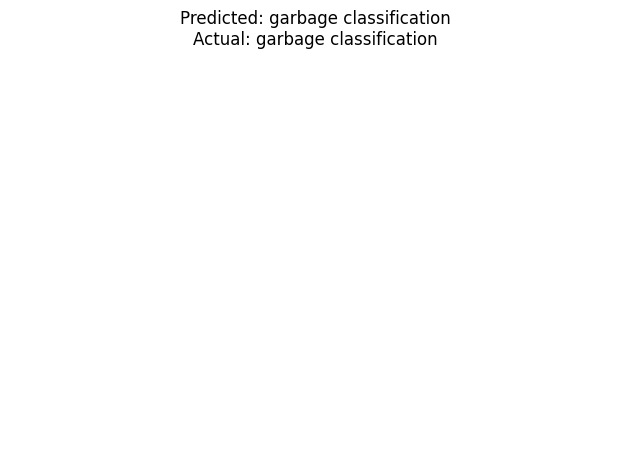

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from Tensor
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of validation data
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Get predictions
model.eval()
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i].cpu())
    plt.title(f'Predicted: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


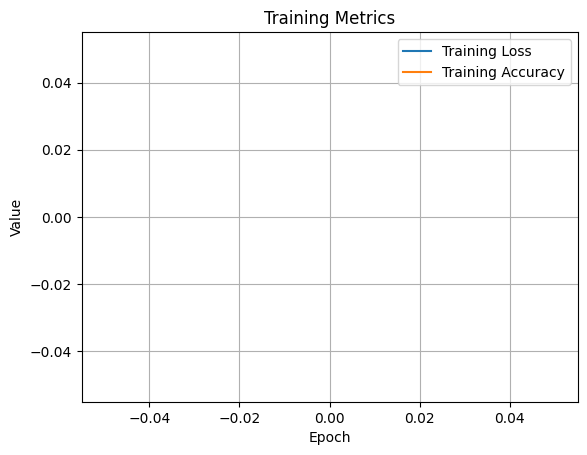

In [ ]:
train_losses = []
train_accuracies = []

# Inside training loop:
# train_losses.append(running_loss/len(train_loader))
# train_accuracies.append(correct/len(train_dataset))

# Then after training:
plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Metrics")
plt.legend()
plt.grid(True)
plt.show()


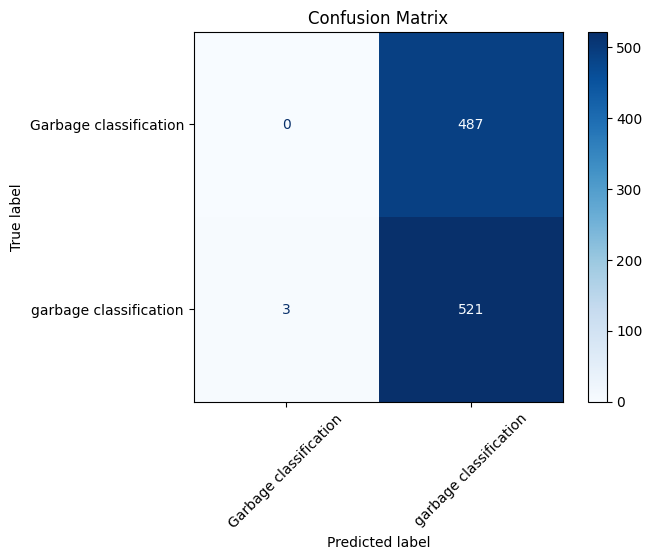

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
